In [60]:
# Array Computation
import numpy as np
from numpy import (ones, log10, sin, pi)

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Signal processing
import scipy.signal as sig
import scipy.fftpack as fft

# Add the path with the pnoise and pll modules 
import plldesigner.pnoise as pn
import plldesigner.sdmod as sdmod

# Folding of the $\Sigma-\Delta$-noise by the PFD-CP non-linearity

In the previous entry the phase noise introduced by using a MASH $\Sigma-\Delta$ modulator in a fractional-N frequency sinthesizer was introduced  [1](http://jfosorio.github.io/blog/2014/06/09/sigma-delta-modulator-phase-noise-in-fractional-n-plls/). The noise as calculated in that section is a good representation of the expected noise at the ouptut of the fractional divider, but it does not account for non-linear effects. 

The main non-linear effect in a frequency sinthesizer is normally related with the comparision of the frequency output with the reference. This effect will be analysed here for a PFD-CP comparator. In PFD-CP comparators the non-linearity is due mainly to three different aspects: first, the PFD-CP dead-zone creates an abroupt change in the phase transfer function when the phase error is close to zero. Second, the difference between up and down currents create differences between the slope of the curve for positive and negative phase errors. Third, the CP finite output impedence creates dependence of the pumped current with the ouptut voltage.

A simple, and fast, method to assest the noise is first demostrated in [Muer2003] and is shown in Fig.1. This model can account for the first two type of artifacts but it can not reproduce the fact that the linearity changes dinamically with the output voltage of the CP.
<br>
<img src="images/Linearity_technique.png" alt="Technique to predict noise folding" width="700">
<center> Figure 1. Technique to calculate the effect of the linearity in the noise </center>
<br>

The function $g_{CP}(out)$ is defined as the function that captures the linearity of the CP, for and input $\phi$  it gives the equivalente $\phi_{out}$ that would be required using an ideal CP to produce the current observed using $\phi$. This function can founded by sweeping the difference delay of the reference and the divider signal at the input of the PFD and mesuring the output of the CP, $i_{CP}(t, \phi)$, and calculating the average current over a period $g_{CP}(\tau)$, scaled by the total current $I_{CP}$, as:

$$
g_{CP}(\phi) = \cfrac{1}{I_{CP}} \cfrac{1}{T_{ref}} \int_T i_{cp}(t,\phi) dt.
$$

The power spectral density (PSD) of the phase noise, refered to the input, can be calculated then by using the FFT.

In order to calculate $\phi_{error}[i]$ it is necesary to substract the mean phase from the phase output of the fractional divider. The mean value of the phase is substracted from the phase of the fractional divider, as a phase locked loop will, after some transient, correct for the mean value.   The frequency desviation, at the output of the fractional divider, can be calculated, as shown  in the previous notebook  as: 

$$
   \Delta_{f_{div}(z)} = \cfrac{f_{in}}{N+f(z)}\left(1 - \cfrac{H_s(z) \Delta_{q}(z)}{N+f(z)}\right),
$$

where $H_s(z) \Delta_{q}(z)$ is the instantaneous changes made by the SDM.  The quantity $H_s(z) \Delta_{q}(z)$ can be also represented as $\Delta_{N}(z)-f(z)$, this is the raw output of the SDM, $\Delta_N(z)$,  minus the desired value, $f(z)$. Going back to the previous expression, and given than we are interestered only in the frequency error, it is posible to write an expersion for the frequency error: 

$$
e_{f,err}(z) = \cfrac{f_{in}}{N+f(z)}\left(\cfrac{\Delta_{N}(z)-f(z)}{N+f(z)}\right),
$$

Integrating the frequency error the phase noise can be found:

$$
\phi_{error}(z) = 2 \pi f_{ref} \left(\cfrac{\Delta_{N}(z)-f(z)}{N+f(z)}\right) \cfrac{T_{ref}}{1-z^{-1}},
$$
that can be further simplyfied as:

$$
\phi_{error}(z) = 2 \pi \cfrac{1}{1-z^{-1}} \left(\cfrac{\Delta_{N}(z)-f(z)}{N+f(z)}\right).
$$

This method is ilustrated with Python and the plldesigner toolkit in the following subsections. 


## Model for the non-linearity CP

The follow

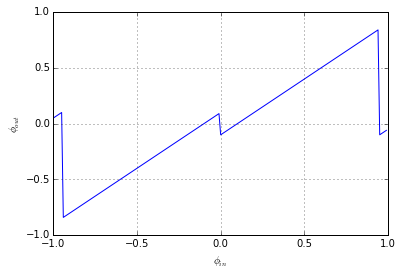

In [94]:
def g(phi_er,k,t_dead=0,mod=1):
    phi_er_mod = np.fmod(phi_er,mod-t_dead/2)
    t_dead = t_dead * ( 2.0*(phi_er > 0) - 1.0)
    phi_out = k[0]+k[1]*(phi_er_mod-t_dead) + \
                   k[2]*(phi_er_mod-t_dead)**2 + \
                   k[3]*(phi_er_mod-t_dead)**3
    return phi_out

phi_error = np.arange(-1,1,0.01)
plt.plot(phi_error,g(phi_error, (0, 1, 0, 0), 0.1, 1))
plt.grid(True)
plt.xlabel('$\phi_{in}$')
plt.ylabel('$\phi_{out}$')

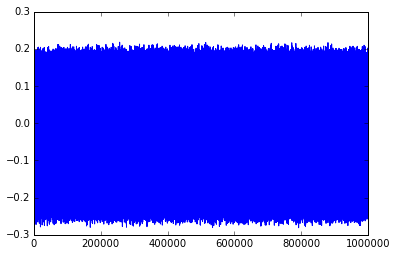

In [64]:
# Load the pnoise and SDM modules
# Parameters 
NsdBits = 19
fref = 27.6e6
Tref = 1.0/fref
Navg = 50.253223
Nint = np.floor(Navg)

# Create a SDM sequency 
fracnum = ((0.253222*2**NsdBits)*ones(1000000)).astype(int)
sd, per = sdmod.gen_mash(3,NsdBits,fracnum)

# Phi_er at the output equals \sum{\DeltaN*fref}*Tref
phi_err = 2*pi*(sd-fracnum[0]/2**NsdBits).cumsum()/Navg
plt.plot(phi_err)

This inital phase, that is not corrected by the integrator, is remove by the loop after the system converges. Thus, after a initial transient, the output converges to:

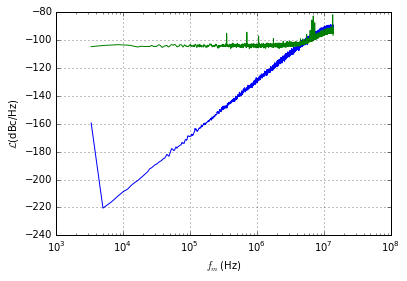

In [69]:
phi_err -= phi_err.mean()
# Calculate th spectrum

nperseg = 2**14
f, Phi2_err = sig.welch(phi_err, fref, window='blackman', 
                        nperseg=nperseg)
rbw = fref/2/(len(f)-1)
ind = f<1e10
sim = pn.Pnoise(f[ind],10*log10(Phi2_err[ind]/2), label='simulated')
sim.plot()
# ERROR
phi_err_nonlin = g(phi_err, (0, 1, 0, 0), 0.1, 1)
f, Phi2_err_nonlin = sig.welch(phi_err_nonlin, fref, window='blackman',
                               nperseg=nperseg)
sim_nonlin = pn.Pnoise(f[ind],10*log10(Phi2_err_nonlin[ind]/2), label='simulated')
sim_nonlin.plot()
plt.grid(True)


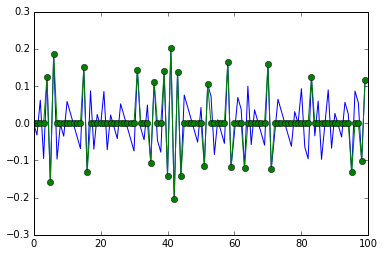

In [70]:
plt.plot(phi_err[0:100])
plt.plot(phi_err_nonlin[0:100],'-o')

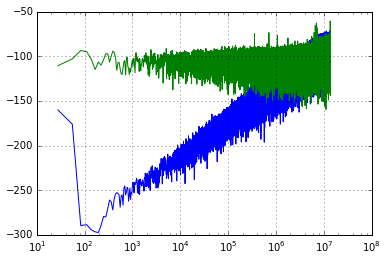

In [71]:

L = len(phi_err)
N=L
fs = fref
w = sig.blackman(L)
# Linear plot
Yx = fft.fft(w*phi_err,N)
Sxx = abs(Yx[0:N/2]*Yx[0:N/2].conj()/sum(w**2)/fs)
Sxx[1:] = abs(2*Sxx[1:])
f = np.linspace(0,fs/2,len(Sxx))
plt.semilogx(f,10*log10(Sxx))

Yx = fft.fft(w*phi_err_nonlin,N)
Sxx = abs(Yx[0:N/2]*Yx[0:N/2].conj()/sum(w**2)/fs)
Sxx[1:] = abs(2*Sxx[1:])
f = np.linspace(0,fs/2,len(Sxx))
plt.semilogx(f,10*log10(Sxx))
plt.grid(True)
#sim_nonlin.plot()
#sim.plot()

In [87]:
a = np.array([-1,-2,1,2])

In [91]:
(a > 0)*2.0-1

array([-1., -1.,  1.,  1.])